<a href="https://colab.research.google.com/github/ChristopheGraveline064/CDA_mesurement/blob/main/cda_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Load Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import os

datapath = '/content/drive/MyDrive/aerostick_data/'
df_feature_file = {}
df_target_file = {}

# Load CSV
for filename in os.listdir(datapath):
  #N.B details = features when naming files
  if filename.endswith('.csv') and filename.startswith('tmp-det_AI'):
    print(f'load {filename}')
    df_feature = pd.read_csv(os.path.join(datapath, filename))
    df_feature_file[filename] = df_feature
    print(df_feature.shape)

#TODO the file may or may not have a header
for filename in os.listdir(datapath):
  if filename.endswith('.csv') and filename.startswith('tmp-sum_AI'):
    print(f'load {filename}')
    df_target =  pd.read_csv(os.path.join(datapath, filename), header=None) #Target files do no countain a header
    #Drop the fist two columns that contains index and test name
    df_target = df_target.drop(columns=[df_target.columns[0],df_target.columns[1]])
    df_target_file[filename] = df_target
    print(df_target.shape)

#TODO Drop non-feature columns if needed
#df_target = df_target.drop(columns=[df_target.columns[0],df_target.columns[1]]) # Drop the first column by index


load tmp-det_AI1__=TireTest_Sat Jul 26 083913 2025.csv
(3117, 6)
load tmp-det_AI2__=TireTest_Fri Jul 25 052355 2025.csv
(2797, 6)
load tmp-det_AI3__=TireTest_Tue Jul 22 094322 2025.csv
(3770, 6)
load tmp-det_AI4__=TireTest_Mon Jul 21 095619 2025.csv
(3629, 6)
load tmp-sum_AI1__=TireTest_Sat Jul 26 083913 2025.csv
(30, 5)
load tmp-sum_AI2__=TireTest_Fri Jul 25 052355 2025.csv
(30, 5)
load tmp-sum_AI3__=TireTest_Tue Jul 22 094322 2025.csv
(35, 5)
load tmp-sum_AI4__=TireTest_Mon Jul 21 095619 2025.csv
(30, 5)


#Data Processing

In [4]:
import tensorflow as tf
import numpy as np
import re

features = []
targets = []

target_column = -1  # Assuming this is where your target/label is in cda

for file_name, target_df in df_target_file.items():
  print(f'Process: {file_name}')
  file_tag = re.search(r"AI(\d+)", file_name)

  cda = target_df.values.astype(np.float32)

  #extract the corresponding features file
  if file_tag:
    ai_number = file_tag.group(1)  # Extract the number after AI
    # Reconstruct the matching key for sum_dict
    for feat_key in df_feature_file.keys():
      if re.search(fr"det_AI{ai_number}(?!\d)", feat_key):  # \b ensures 'AI7' doesn't match 'AI70'
        print(f"Found: {feat_key}")
        data = df_feature_file[feat_key].values.astype(np.float32)

  for i in range(len(cda)):
      # Extract the label
      label = cda[i, target_column]

      # Extract the variable-length sequence (rows from data)
      #TODO the number of column used may change
      seq1 = data[int(cda[i, 0]):int(cda[i, 1]), 2:]  # skip column 0, use all others
      seq2 = data[int(cda[i, 2]):int(cda[i, 3]), 2:]
      sequence = np.concatenate([seq1, seq2], axis=0)

      features.append(sequence)  # variable-length 2D array
      targets.append(label)


# Convert features to a RaggedTensor
ragged_features = tf.ragged.constant(features, dtype=tf.float32)

# Convert targets to a normal tensor
targets = tf.convert_to_tensor(targets, dtype=tf.float32)



Process: tmp-sum_AI1__=TireTest_Sat Jul 26 083913 2025.csv
Found: tmp-det_AI1__=TireTest_Sat Jul 26 083913 2025.csv
Process: tmp-sum_AI2__=TireTest_Fri Jul 25 052355 2025.csv
Found: tmp-det_AI2__=TireTest_Fri Jul 25 052355 2025.csv
Process: tmp-sum_AI3__=TireTest_Tue Jul 22 094322 2025.csv
Found: tmp-det_AI3__=TireTest_Tue Jul 22 094322 2025.csv
Process: tmp-sum_AI4__=TireTest_Mon Jul 21 095619 2025.csv
Found: tmp-det_AI4__=TireTest_Mon Jul 21 095619 2025.csv


In [5]:
flatten = False #use when using XGBoost

# Pad the ragged features
padded_features = ragged_features.to_tensor(default_value=0.0)

#convert  to numpy
padded_features_np = padded_features.numpy()
targets_np = targets.numpy()
if flatten:
  padded_features_np = padded_features_np.reshape(125, 295 * 4)

print(f"Sequances dim: {padded_features_np.shape}")
print(f"Target dim:{targets_np.shape}")




Sequances dim: (125, 295, 4)
Target dim:(125,)


In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(padded_features_np, targets_np, test_size=0.2, random_state=42)

#X_train = X_train[:10]
#y_train = y_train[:10]

print(f"X_train dim: {X_train.shape}")
print(f"y_train dim: {y_train.shape}")

X_train dim: (100, 295, 4)
y_train dim: (100,)


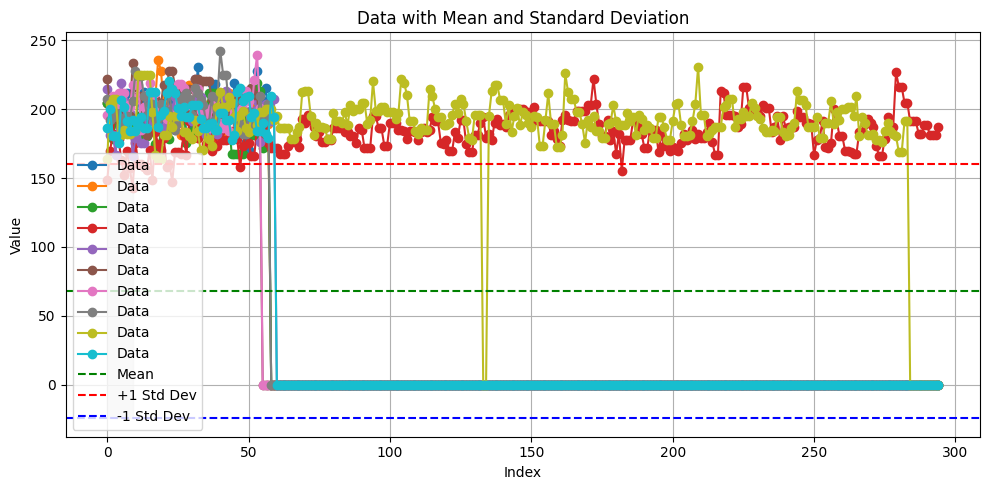

In [7]:
import matplotlib.pyplot as plt

# Calculate mean and standard deviation

data = X_train[:10, :295, 0]
#data[data == 0] = np.nan
mean = np.mean(data)
std_dev = np.std(data)

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(data.T, marker='o', label='Data')
plt.axhline(mean, color='green', linestyle='--', label='Mean')
plt.axhline(mean + std_dev, color='red', linestyle='--', label='+1 Std Dev')
plt.axhline(mean - std_dev, color='blue', linestyle='--', label='-1 Std Dev')
plt.fill_between(range(len(data)), mean - std_dev, mean + std_dev, color='gray', alpha=0.2)

# Labels and legend
plt.title('Data with Mean and Standard Deviation')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


[0.2558 0.2747 0.2699 0.2804 0.2738 0.2752 0.263  0.2621 0.2641 0.264
 0.2614 0.262  0.2649 0.2786 0.2528 0.2857 0.261  0.2819 0.2537 0.269
 0.273  0.272  0.2588 0.2563 0.2634]


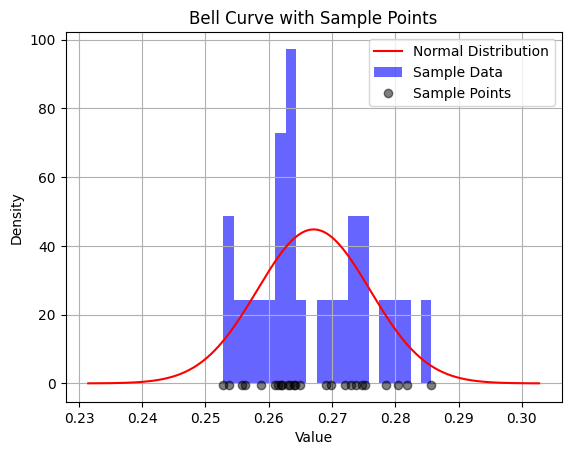

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

# Generate or use your sample data
data = y_test#targets_np #  np.random.normal(loc=0, scale=1, size=100)  # Replace this with your actual data

print(y_test)

# Fit a normal distribution to the data
mean = np.mean(data)
std = np.std(data)

# Generate x values for the bell curve
x = np.linspace(mean - 4*std, mean + 4*std, 1000)
pdf = stats.norm.pdf(x, mean, std)

# Plot the bell curve
plt.plot(x, pdf, label='Normal Distribution', color='red')

# Plot the sample points as a histogram
plt.hist(data, bins=20, density=True, alpha=0.6, color='blue', label='Sample Data')

# Add the sample points as dots along the x-axis
y_min = -0.01 * max(pdf)
plt.plot(data, [y_min]*len(data), 'ko', alpha=0.5, label='Sample Points')

plt.title('Bell Curve with Sample Points')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()


#Model

##RNN, LSTM, GRU

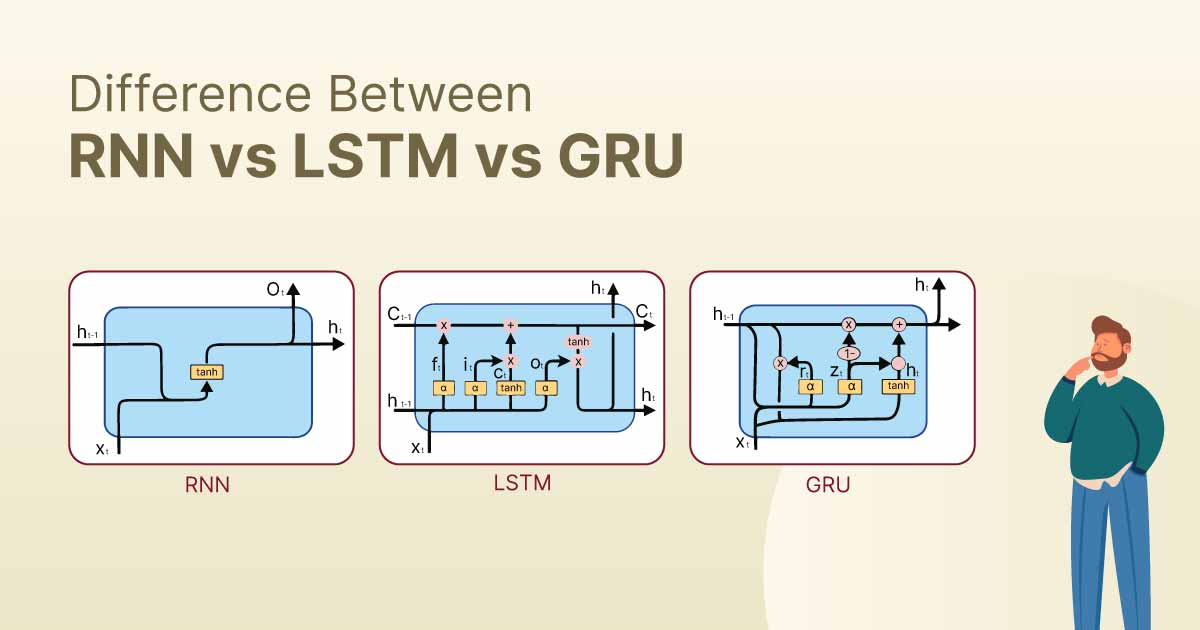

In [290]:
import tensorflow as tf
from xgboost import XGBRegressor
import numpy as np


import random
import os

# Set global seeds
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)


def correlation_loss(y_true, y_pred):
    x = y_true - tf.reduce_mean(y_true)
    y = y_pred - tf.reduce_mean(y_pred)
    corr = tf.reduce_sum(x * y) / (
        tf.sqrt(tf.reduce_sum(tf.square(x))) * tf.sqrt(tf.reduce_sum(tf.square(y))) + 1e-8)
    print("corr {}".format(corr))


    return 1 - corr  # 1 - correlation, so that lower = better

'''def correlation_loss(y_true, y_pred):
    pearson_r, _ = tf.contrib.metrics.streaming_pearson_correlation(y_pred, y_true)
    print("corr {}".format(pearson_r))
    return 1-pearson_r**2'''

mse_loss = tf.keras.losses.MeanSquaredError()

def combined_loss(y_true, y_pred):
    mse = mse_loss(y_true, y_pred)
    return mse + 0.1*correlation_loss(y_true, y_pred)

def single_head_attention(x):
    # Attention mechanism
    feature_dim = x.shape[-1]

    attention = tf.keras.layers.Dense(1, activation='tanh')(x)
    attention = tf.keras.layers.Flatten()(attention)
    attention = tf.keras.layers.Activation('softmax')(attention)
    attention = tf.keras.layers.RepeatVector(feature_dim)(attention)
    attention = tf.keras.layers.Permute([2, 1])(attention)

    # Apply attention to Bi-GRU outputs
    weighted = tf.keras.layers.Multiply()([x, attention])
    summed = tf.keras.layers.Lambda(lambda x: tf.reduce_sum(x, axis=1))(weighted)
    return summed

def multi_head_attention(x, num_heads = 8, head_dim = 32):
    multi_head_output = tf.keras.layers.MultiHeadAttention(
      num_heads=num_heads,         # You can choose 4, 8, etc.
      key_dim=head_dim           # Dimensionality of each head
    )(x, x, x)

    # (Optional) Add & Normalize (if you want Transformer-like architecture)
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x + multi_head_output)

    # Pooling or reduction
    summed = tf.keras.layers.GlobalAveragePooling1D()(x)
    return summed

def rnn_layer(model_type, node_n = 128, return_sequences= False):
    if model_type == 'RNN':
      return tf.keras.layers.SimpleRNN(
          node_n,
          return_sequences=return_sequences,  # Required for attention
          kernel_initializer=tf.keras.initializers.GlorotUniform(seed=SEED),
          recurrent_initializer=tf.keras.initializers.Orthogonal(seed=SEED),
          bias_initializer=tf.keras.initializers.Zeros()
      )
    elif model_type == 'LSTM':
      return tf.keras.layers.LSTM(
          node_n,
          return_sequences=return_sequences,  # Required for attention
          kernel_initializer=tf.keras.initializers.GlorotUniform(seed=SEED),
          recurrent_initializer=tf.keras.initializers.Orthogonal(seed=SEED),
          bias_initializer=tf.keras.initializers.Zeros()
      )
    elif model_type == 'GRU':
      return tf.keras.layers.GRU(
          node_n,
          return_sequences=return_sequences,  # Required for attention
          kernel_initializer=tf.keras.initializers.GlorotUniform(seed=SEED),
          recurrent_initializer=tf.keras.initializers.Orthogonal(seed=SEED),
          bias_initializer=tf.keras.initializers.Zeros()
      )


def build_model(model_type, attention=False, multi_head=0, bidirect=False):
  input_shape = (None, padded_features_np.shape[2])

  # Input
  inputs = tf.keras.Input(shape=input_shape)

  cell = rnn_layer(model_type, return_sequences = (attention or multi_head))

  if bidirect:
    x = tf.keras.layers.Bidirectional(cell)(inputs)
  else:
    x = cell(inputs)


  if multi_head > 0:
    summed = multi_head_attention(x, num_heads = multi_head)
  elif attention:
    summed = single_head_attention(x)
  else:
    summed = x


  output = tf.keras.layers.Dense(
    1,
    kernel_initializer=tf.keras.initializers.GlorotUniform(seed=SEED),
    bias_initializer=tf.keras.initializers.Zeros()
  )(summed)

  # Model
  model = tf.keras.Model(inputs=inputs, outputs=output)


  print("Compile Model")
  model.compile(optimizer='adam', loss='mse', metrics=['mae'])
  #model.compile(optimizer='adam', loss=combined_loss, metrics=['mae'])

  return model

In [8]:
#from tensorflow.keras.utils import plot_model

#plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

##Neural Ordinary Differential Equations (arXiv:1806.07366)

#Train

##Regresion

In [28]:
#tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs")
from tensorflow.keras.callbacks import EarlyStopping
#For XGBoost
from sklearn.metrics import mean_squared_error, mean_absolute_error


early_stopping = EarlyStopping(
    monitor='val_loss',     # What metric to monitor
    patience=5,             # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restores model weights from the epoch with the best value of the monitored quantity
)

#tf.keras.backend.clear_session()

batch_s = 8
epochs_n = 50

training_sizes = [10, 30, 50, 70, 100]

'''xgboost_mae  = []
model = build_model('XGBoost')
for size in training_sizes:
  history = model.fit(X_train[:size], y_train[:size])

  y_pred = model.predict(X_test)

  # Evaluate
  mse = mean_absolute_error(y_test, y_pred)
  print(f"Test MSE: {mse}")
  xgboost_mae.append(mse)'''


'''gru_mae  = []
model = build_model('GRU')
print(type(model))
for size in training_sizes:
  history = model.fit(X_train[:size], y_train[:size], epochs=epochs_n, batch_size=batch_s, validation_data=(X_test, y_test), callbacks=[early_stopping])
  gru_mae.append(model.evaluate(X_test, y_test)[1])'''


'''lstm_mae  = []
model = build_model('LSTM')
for size in training_sizes:
  history = model.fit(X_train[:size], y_train[:size], epochs=epochs_n, batch_size=batch_s, validation_data=(X_test, y_test), callbacks=[early_stopping])
  lstm_mae.append(model.evaluate(X_test, y_test)[1])'''


bigru_mae  = []
model = build_model('attention')
for size in training_sizes:
  history = model.fit(X_train[:size], y_train[:size], epochs=epochs_n, batch_size=batch_s, validation_data=(X_test, y_test), callbacks=[early_stopping])
  bigru_mae.append(model.evaluate(X_test, y_test)[1])

TypeError: build_model() missing 1 required positional argument: 'attention'

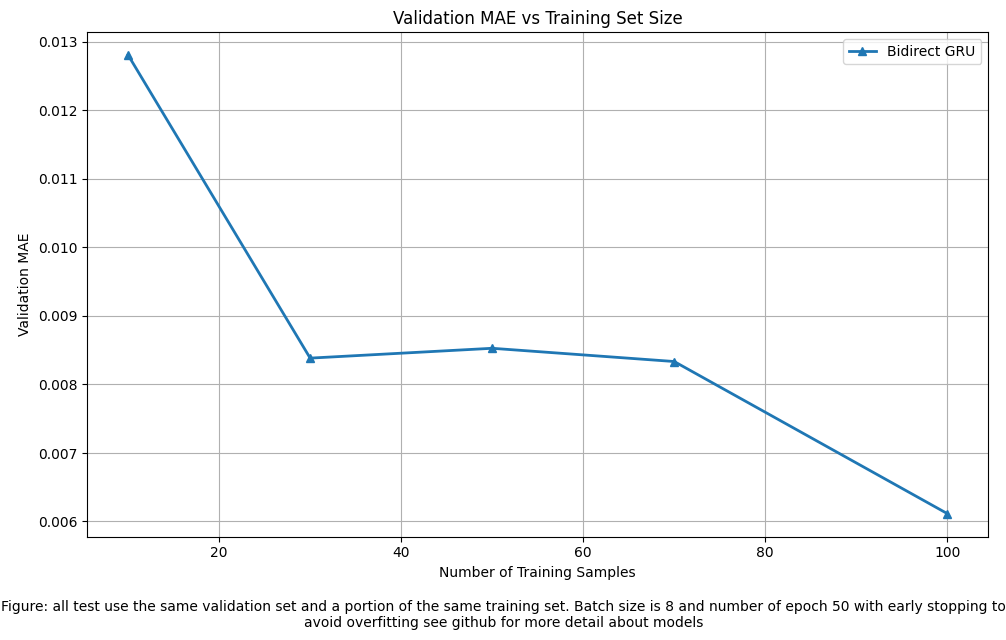

In [144]:
import matplotlib.pyplot as plt

# Example data (replace with your actual values)

# Plotting
plt.figure(figsize=(10, 6))
#plt.plot(training_sizes, xgboost_mae, marker='o', label='LSTM', linewidth=2)
#plt.plot(training_sizes, lstm_mae, marker='o', label='LSTM', linewidth=2)
#plt.plot(training_sizes, gru_mae, marker='s', label='GRU', linewidth=2)
plt.plot(training_sizes, bigru_mae, marker='^', label='Bidirect GRU', linewidth=2)

# Labels and title
plt.xlabel('Number of Training Samples')
plt.ylabel('Validation MAE')
plt.title('Validation MAE vs Training Set Size')
plt.legend()
plt.grid(True)


plt.figtext(0.5, -0.05,
            'Figure: all test use the same validation set and a portion of the same training set. Batch size is 8 and number of epoch 50 with early stopping to avoid overfitting see github for more detail about models',
            wrap=True, horizontalalignment='center', fontsize=10)


plt.tight_layout()

# Show plot
plt.show()


## Simple Training

In [ ]:
#tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs")
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',     # What metric to monitor
    patience=5,             # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restores model weights from the epoch with the best value of the monitored quantity
)

model = build_model('RNN', attention=True, multi_head=8, bidirect=True)

model.summary()

#history = model.fit(X_train, y_train, epochs=75, batch_size=4, validation_data=(X_test, y_test), callbacks=[tensorboard_callback])
history = model.fit(X_train, y_train, epochs=75, batch_size=8, validation_data=(X_test, y_test), callbacks=[early_stopping])

#history = model.fit(X_train, y_train)

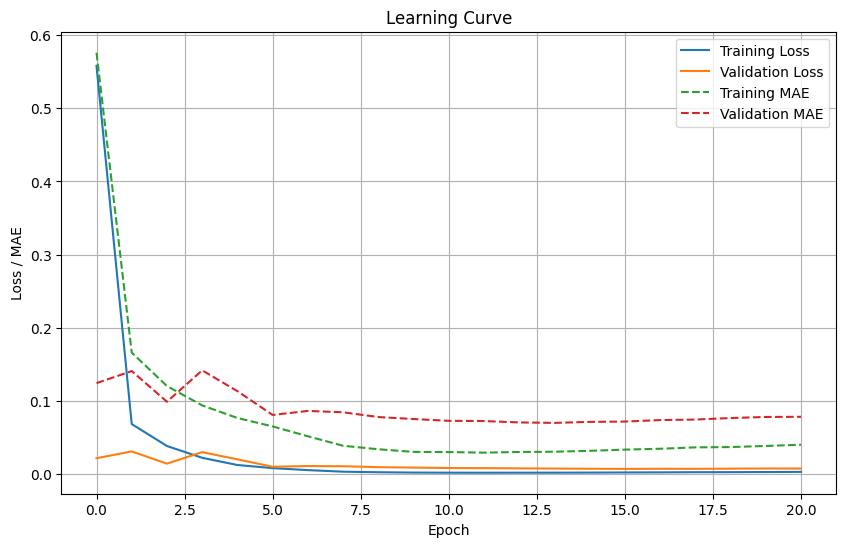

In [270]:
import matplotlib.pyplot as plt

# Plot training & validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

# Optional: plot additional metrics like MAE
if 'mae' in history.history:
    plt.plot(history.history['mae'], label='Training MAE', linestyle='--')
    plt.plot(history.history['val_mae'], label='Validation MAE', linestyle='--')

plt.title('Learning Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss / MAE')
plt.legend()
plt.grid(True)
plt.show()


#Evaluate

In [271]:

#For XGBoost
from sklearn.metrics import mean_squared_error, mean_absolute_error


y_pred = model.predict(X_test)

print(y_pred.shape)
print(y_test.shape)

# Evaluate
mse = mean_absolute_error(y_test, y_pred)
print(f"Test MAE: {mse}")

print(combined_loss(y_test, y_pred.flatten()))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step
(25, 1)
(25,)
Test MAE: 0.07157031446695328
corr -0.1412913054227829
tf.Tensor(0.12097573, shape=(), dtype=float32)


In [272]:
model.evaluate(X_test, y_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.0068 - mae: 0.0716


[0.006846606731414795, 0.07157029956579208]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
(100, 1)
(100,)
Correlation between feature 0 and 1: 0.07


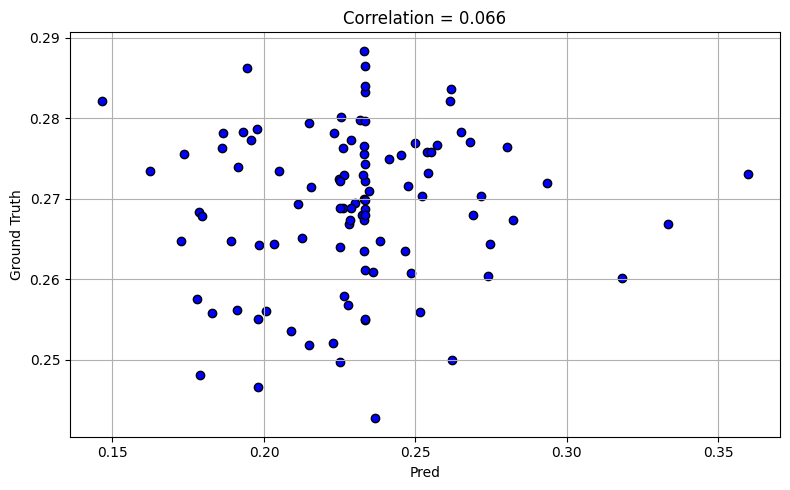

In [273]:
from scipy.stats import pearsonr

y = model.predict(X_train)

print(y.shape)
print(y_train.shape)

x = y_train
y = y.flatten()
corr, _ = pearsonr(x, y)
print(f"Correlation between feature 0 and 1: {corr:.2f}")


# Plot
plt.figure(figsize=(8, 5))
plt.scatter(y, x, color='blue', edgecolor='k')
plt.title(f"Correlation = {corr:.3f}")
plt.xlabel("Pred")
plt.ylabel("Ground Truth")
#plt.xlim(25, 29)
#plt.ylim(26.705, 26.715)
plt.grid(True)
plt.tight_layout()
plt.show()

Correlation between feature 0 and 1: -0.14


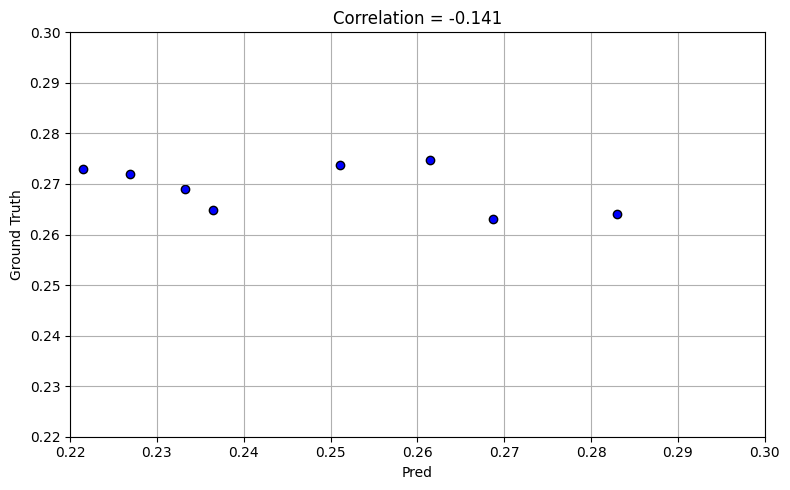

In [274]:
from scipy.stats import pearsonr


ground_truth = y_test
pred = y_pred.flatten()
corr, _ = pearsonr(pred, ground_truth)
print(f"Correlation between feature 0 and 1: {corr:.2f}")


# Plot
plt.figure(figsize=(8, 5))
plt.scatter(pred, ground_truth, color='blue', edgecolor='k')
plt.title(f"Correlation = {corr:.3f}")
plt.xlabel("Pred")
plt.ylabel("Ground Truth")
plt.xlim(0.22, 0.3)
plt.ylim(0.22, 0.3)
plt.grid(True)
plt.tight_layout()
plt.show()

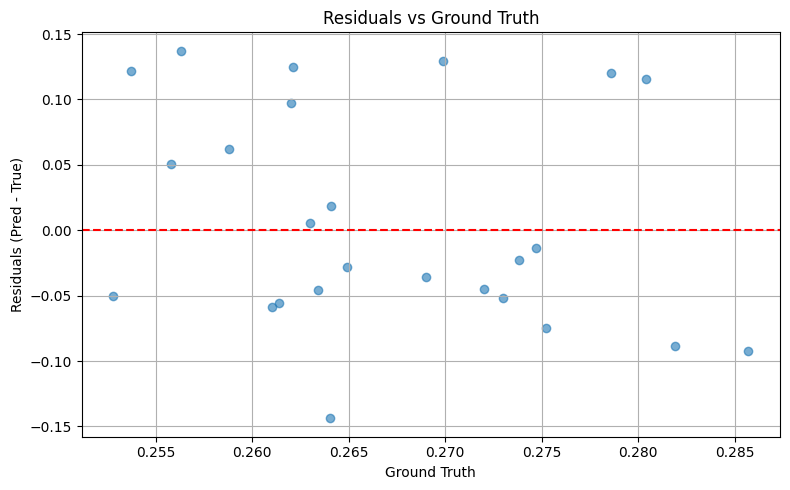

In [275]:
import matplotlib.pyplot as plt

# y_pred and y_true should be numpy arrays
residuals = pred - ground_truth

plt.figure(figsize=(8, 5))
plt.scatter(ground_truth, residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs Ground Truth")
plt.xlabel("Ground Truth")
plt.ylabel("Residuals (Pred - True)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir=./logs

\begin{table}[h!]
\centering
\begin{tabular}{ll|ccc|ccc}
\toprule
& & \multicolumn{3}{c|}{\textbf{Unidirectional}} & \multicolumn{3}{c}{\textbf{Bidirectional}} \\
\textbf{Attention} &  & \textbf{RNN} & \textbf{GRU} & \textbf{LSTM} & \textbf{RNN} & \textbf{GRU} & \textbf{LSTM} \\
\midrule
\multirow{2}{*}{No Attention} & Structure & ✓ & ✓ & ✓ & ✓ & ✓ & ✓ \\
                              & Use Case  & ✓ & ✓ & ✓ & ✓ & ✓ & ✓ \\
\midrule
\multirow{2}{*}{Single-head}  & Structure & ✓ & ✓ & ✓ & ✓ & ✓ & ✓ \\
                              & Use Case  & ✓ & ✓ & ✓ & ✓ & ✓ & ✓ \\
\midrule
\multirow{2}{*}{Multi-head}   & Structure & ✗* & ✗* & ✗* & ✗* & ✗* & ✗* \\
                              & Use Case  & ✗* & ✗* & ✗* & ✗* & ✗* & ✗* \\
\bottomrule
\end{tabular}
\caption{Comparison of RNN, GRU, and LSTM in unidirectional and bidirectional modes with different attention mechanisms. (*: Multi-head attention is typically used in Transformer-based architectures rather than classic RNNs.)}
\end{table}




##RNN (epoch: 75, batch size: 4):

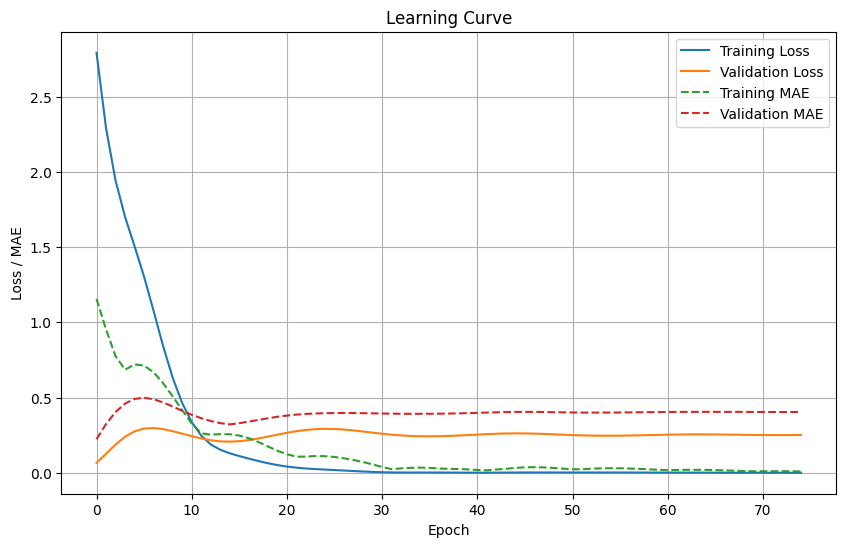

##LSTM (epoch: 75, batch size: 4)

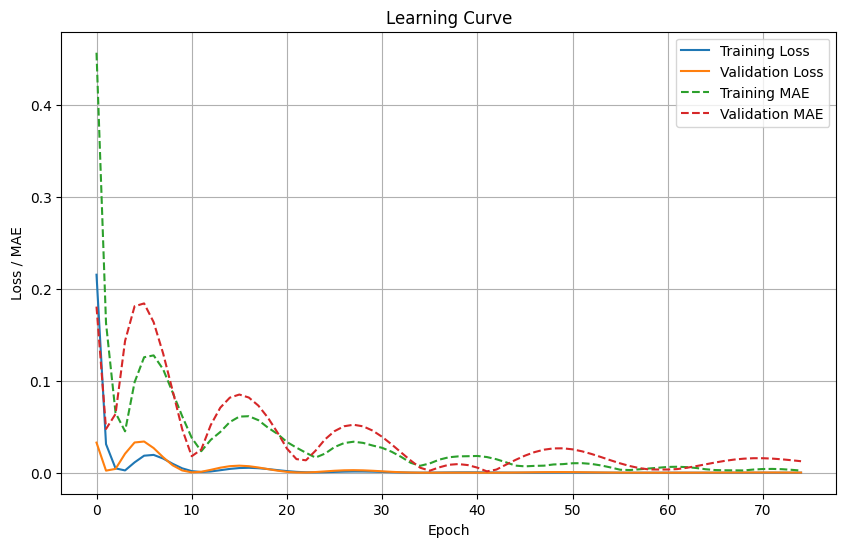

##GRU (ephoch: 75, batch size: 4)

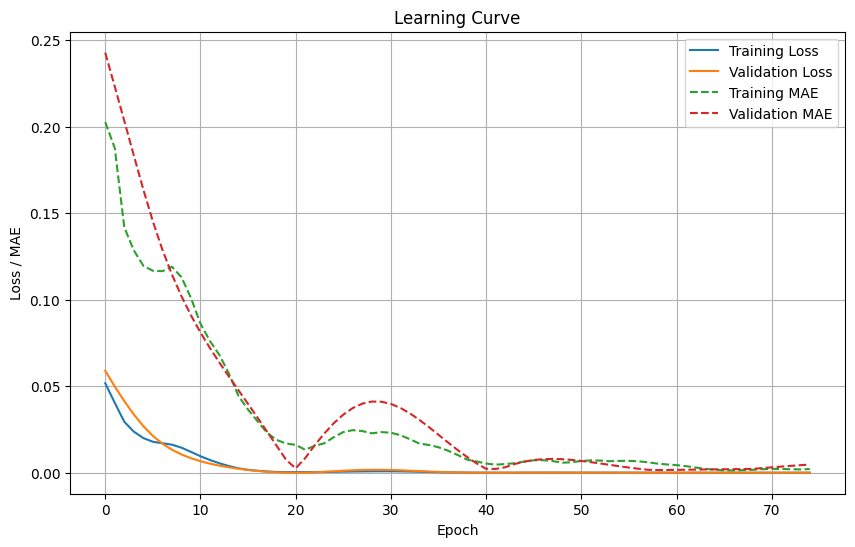

# Skeches

In [16]:

SEED= 42

import tensorflow as tf

input_shape = (None, 4)

# Input
inputs = tf.keras.Input(shape=input_shape)

#x = tf.keras.layers.Bidirectional(
x =  tf.keras.layers.SimpleRNN(
        64,
        return_sequences=True,  # Required for attention
        kernel_initializer=tf.keras.initializers.GlorotUniform(seed=SEED),
        recurrent_initializer=tf.keras.initializers.Orthogonal(seed=SEED),
        bias_initializer=tf.keras.initializers.Zeros()
    )(inputs)
#)(inputs)

# Attention mechanism
attention = tf.keras.layers.Dense(1, activation='tanh')(x)
attention = tf.keras.layers.Flatten()(attention)
attention = tf.keras.layers.Activation('softmax')(attention)
attention = tf.keras.layers.RepeatVector(64)(attention)
attention = tf.keras.layers.Permute([2, 1])(attention)

# Apply attention to Bi-GRU outputs
weighted = tf.keras.layers.Multiply()([x, attention])
summed = tf.keras.layers.Lambda(lambda x: tf.reduce_sum(x, axis=1))(weighted)

# Output layer
output = tf.keras.layers.Dense(
    1,
    kernel_initializer=tf.keras.initializers.GlorotUniform(seed=SEED),
    bias_initializer=tf.keras.initializers.Zeros()
)(summed)

# Build the model
model = tf.keras.Model(inputs=inputs, outputs=output)

In [17]:
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, None, 4)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ simple_rnn_2        │ (None, None, 64)  │      4,416 │ input_layer_5[0]… │
│ (SimpleRNN)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, None, 1)   │         65 │ simple_rnn_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_4 (Flatten) │ (None, None)      │          0 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, None)      │          0 │ flatten_4[0][0]   │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_4     │ (None, 64, None)  │          0 │ activation_4[0][… │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ permute_4 (Permute) │ (None, None, 64)  │          0 │ repeat_vector_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_4          │ (None, None, 64)  │          0 │ simple_rnn_2[0][… │
│ (Multiply)          │                   │            │ permute_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_4 (Lambda)   │ (None, 64)        │          0 │ multiply_4[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 1)         │         65 │ lambda_4[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,546 (17.76 KB)

 Trainable params: 4,546 (17.76 KB)

 Non-trainable params: 0 (0.00 B)

  if model_type == 'RNN' and not flatten:
    model = tf.keras.Sequential([
      tf.keras.layers.Input(shape=(None, padded_features_np.shape[2])),
      tf.keras.layers.SimpleRNN(64, return_sequences=True),
      tf.keras.layers.SimpleRNN(64, return_sequences=False),
      tf.keras.layers.Dense(1)
    ])
  elif model_type == 'LSTM' and not flatten:
    model = tf.keras.Sequential([
      tf.keras.layers.Input(shape=(None, padded_features_np.shape[2])),
      tf.keras.layers.LSTM(
          64,
          return_sequences=False,
          kernel_initializer=tf.keras.initializers.GlorotUniform(seed=SEED),
          recurrent_initializer=tf.keras.initializers.Orthogonal(seed=SEED),
          bias_initializer=tf.keras.initializers.Zeros()
      ),
      tf.keras.layers.Dense(
          1,
          kernel_initializer=tf.keras.initializers.GlorotUniform(seed=SEED),
          bias_initializer=tf.keras.initializers.Zeros()
      )
    ])
  elif model_type == 'GRU' and not flatten:
    print('Build GRU Model')
    model = tf.keras.Sequential([
      tf.keras.layers.Input(shape=(None, padded_features_np.shape[2])),
      tf.keras.layers.GRU(
          128,
          return_sequences=False,
          kernel_initializer=tf.keras.initializers.GlorotUniform(seed=SEED),
          recurrent_initializer=tf.keras.initializers.Orthogonal(seed=SEED),
          bias_initializer=tf.keras.initializers.Zeros()
      ),
      tf.keras.layers.Dense(
          1,
          kernel_initializer=tf.keras.initializers.GlorotUniform(seed=SEED),
          bias_initializer=tf.keras.initializers.Zeros()
      )
    ])
  elif model_type == 'BiGRU' and not flatten:
   model = tf.keras.Sequential([
      tf.keras.layers.Input(shape=(None, padded_features_np.shape[2])),
      tf.keras.layers.Bidirectional(
          tf.keras.layers.GRU(
              128,
              return_sequences=False,
              kernel_initializer=tf.keras.initializers.GlorotUniform(seed=SEED),
              recurrent_initializer=tf.keras.initializers.Orthogonal(seed=SEED),
              bias_initializer=tf.keras.initializers.Zeros()
          )
      ),
      tf.keras.layers.Dense(
        1,
        kernel_initializer=tf.keras.initializers.GlorotUniform(seed=SEED),
        bias_initializer=tf.keras.initializers.Zeros()
      )
    ])
  elif model_type == 'attention':
    input_shape = (None, padded_features_np.shape[2])

    # Input
    inputs = tf.keras.Input(shape=input_shape)

    # Bi-GRU with sequence output
    x = tf.keras.layers.LSTM(
          128,
          return_sequences=True,
          kernel_initializer=tf.keras.initializers.GlorotUniform(seed=SEED),
          recurrent_initializer=tf.keras.initializers.Orthogonal(seed=SEED),
          bias_initializer=tf.keras.initializers.Zeros()
      )(inputs)


    x = tf.keras.layers.Bidirectional(
      tf.keras.layers.LSTM(
          164,
          return_sequences=True,  # Required for attention
          kernel_initializer=tf.keras.initializers.GlorotUniform(seed=SEED),
          recurrent_initializer=tf.keras.initializers.Orthogonal(seed=SEED),
          bias_initializer=tf.keras.initializers.Zeros()
      )
    )(inputs)

    summed = single_head_attention(x)

    # Output layer
    output = tf.keras.layers.Dense(
        1,
        kernel_initializer=tf.keras.initializers.GlorotUniform(seed=SEED),
        bias_initializer=tf.keras.initializers.Zeros()
    )(summed)

    # Build the model
    model = tf.keras.Model(inputs=inputs, outputs=output)
  elif model_type == 'multihead':

    input_shape = (None, padded_features_np.shape[2])

    # Input
    inputs = tf.keras.Input(shape=input_shape)

    # Bi-GRU with sequence output
    x = tf.keras.layers.Bidirectional(
      tf.keras.layers.LSTM(
          164,
          return_sequences=True,  # Required for attention
          kernel_initializer=tf.keras.initializers.GlorotUniform(seed=SEED),
          recurrent_initializer=tf.keras.initializers.Orthogonal(seed=SEED),
          bias_initializer=tf.keras.initializers.Zeros()
      )
    )(inputs)

    summed = multi_head_attention(x)

    # Output layer
    output = tf.keras.layers.Dense(
      1,
      kernel_initializer=tf.keras.initializers.GlorotUniform(seed=SEED),
      bias_initializer=tf.keras.initializers.Zeros()
    )(summed)

    # Model
    model = tf.keras.Model(inputs=inputs, outputs=output)

  elif model_type == 'NN':
    model = tf.keras.Sequential([
      tf.keras.layers.Input(shape=(padded_features_np.shape[1], padded_features_np.shape[2])),  # shape: (timesteps, features)
      tf.keras.layers.Flatten(),  # flatten (timesteps, features) to (timesteps * features)
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(1)
    ])
  elif model_type == 'XGBoost' and flatten:
    model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)

  else:

```
# This is formatted as code
```

